In [19]:
# Cell 1: Imports and Setup

import pandas as pd
import matplotlib.pyplot as plt
import nltk
import random
from wordcloud import WordCloud
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense
import os
import pickle

In [20]:
# Cell 2: Load and Preview Data

df_raw = pd.read_csv('mbti_1.csv')
df_raw.columns = ['mbti_label', 'user_posts']
df_raw.head()

mbti_label                                         user_posts
0       INFJ  'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1       ENTP  'I'm finding the lack of me in these posts ver...
2       INTP  'Good one  _____   https://www.youtube.com/wat...
3       INTJ  'Dear INTP,   I enjoyed our conversation the o...
4       ENTJ  'You're fired.|||That's another silly misconce...

In [21]:
# Cell 3: MBTI Attribute Extraction

mbti_features = df_raw[['mbti_label']].copy()
mbti_features['EI_axis'] = df_raw['mbti_label'].str.extract('(.)[N,S]', 1)
mbti_features['NS_axis'] = df_raw['mbti_label'].str.extract('[E,I](.)[F,T]', 1)
mbti_features['TF_axis'] = df_raw['mbti_label'].str.extract('[N,S](.)[J,P]', 1)
mbti_features['JP_axis'] = df_raw['mbti_label'].str.extract('[F,T](.)', 1)

le_feat = LabelEncoder()
mbti_encoded = mbti_features[['mbti_label']].copy()
mbti_encoded['bin_EI'] = le_feat.fit_transform(mbti_features['EI_axis'])
mbti_encoded['bin_NS'] = le_feat.fit_transform(mbti_features['NS_axis'])
mbti_encoded['bin_TF'] = le_feat.fit_transform(mbti_features['TF_axis'])
mbti_encoded['bin_JP'] = le_feat.fit_transform(mbti_features['JP_axis'])

correlations = mbti_encoded.drop(columns='mbti_label').corr()
correlations.style.background_gradient()

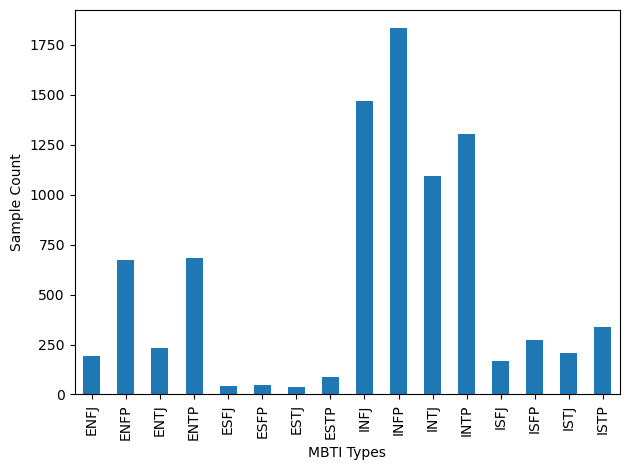

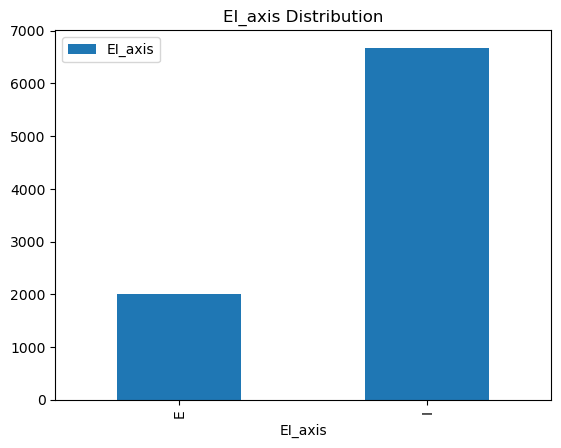

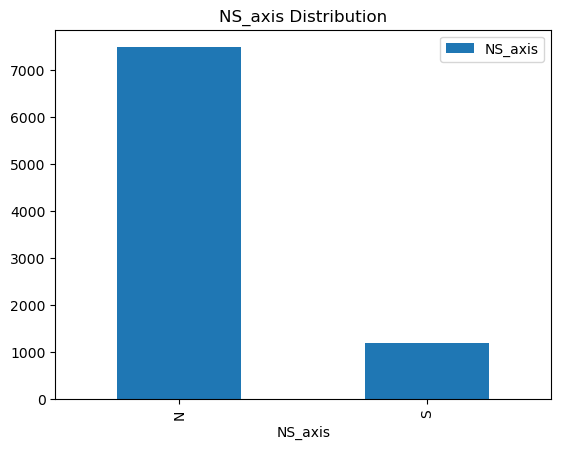

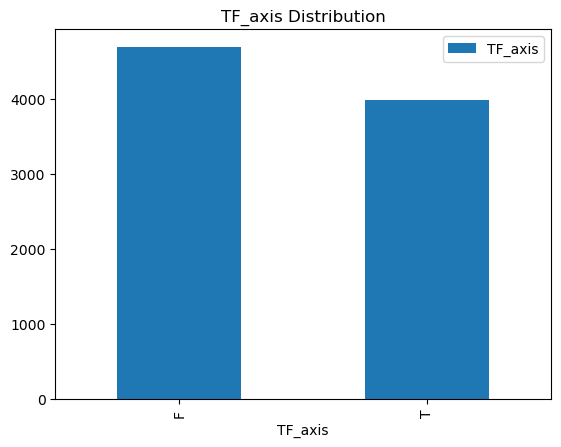

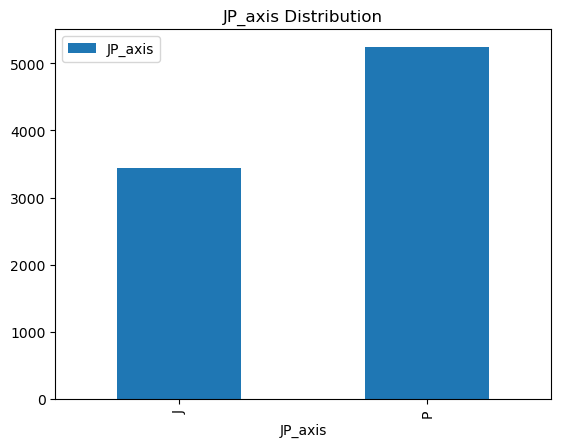

In [22]:
# Cell 4: Distribution Plots

mbti_counts = df_raw.groupby('mbti_label').agg({'mbti_label':'count'})
ax = mbti_counts.plot(kind='bar', legend=None)
ax.set_xlabel("MBTI Types")
ax.set_ylabel("Sample Count")
plt.tight_layout()
plt.show()

for axis in ['EI_axis', 'NS_axis', 'TF_axis', 'JP_axis']:
    mbti_features.groupby(axis).agg({axis: 'count'}).plot(kind='bar')
    plt.title(f'{axis} Distribution')
    plt.show()

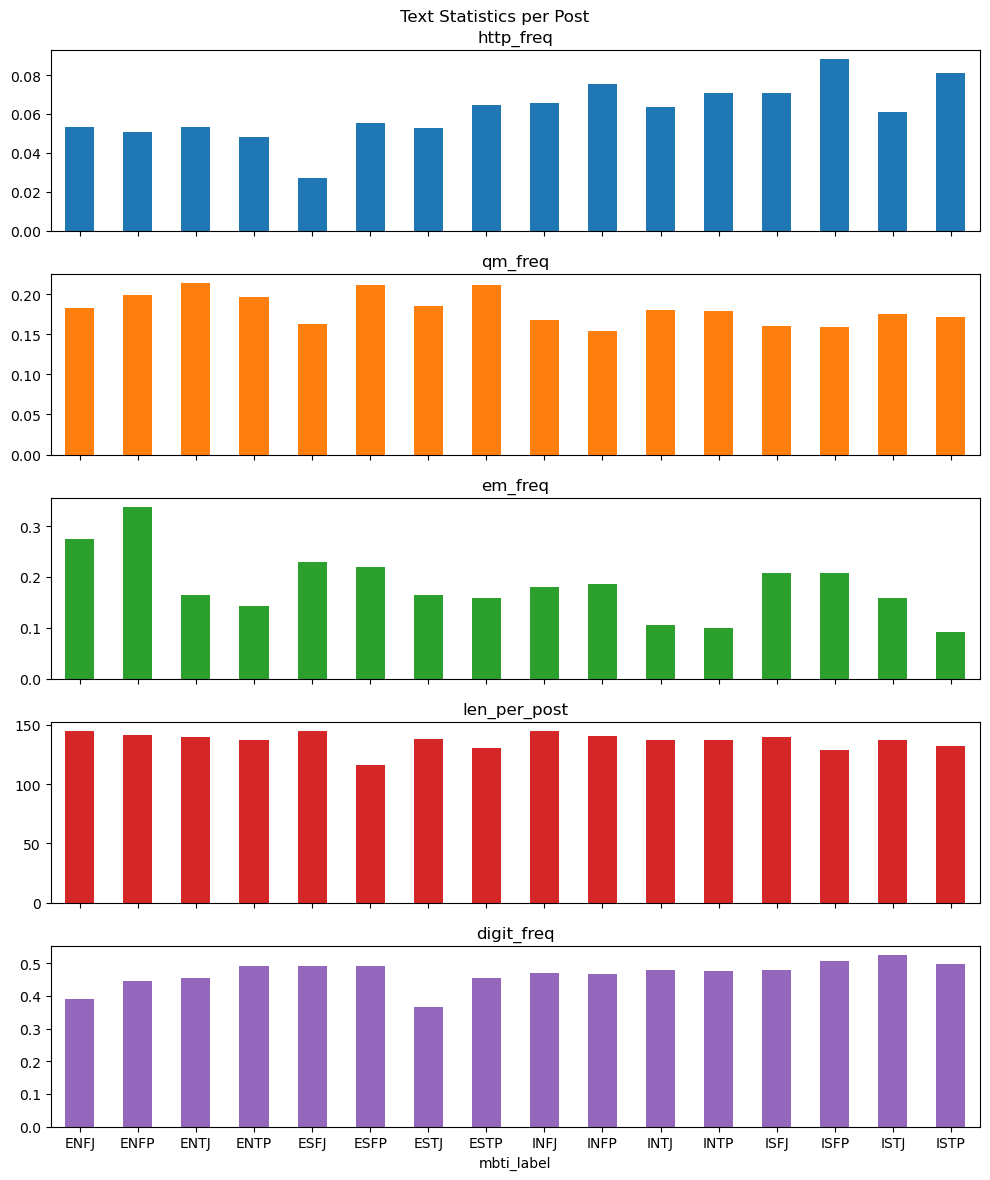

In [23]:
# Cell 5: Basic Textual Feature Engineering

import matplotlib.pyplot as plt

df_posts = df_raw.copy()

# Feature: Frequency of 'http' per 50 posts
df_posts['http_freq'] = df_posts['user_posts'].apply(lambda x: x.count('http') / 50)

# Remove URLs
regex_url = r"(http.*?\s)"
df_posts['no_urls'] = df_posts['user_posts'].replace(regex_url, " ", regex=True)

# Feature: Frequency of question marks and exclamation marks per 50 posts
df_posts['qm_freq'] = df_posts['no_urls'].apply(lambda x: x.count('?') / 50)
df_posts['em_freq'] = df_posts['no_urls'].apply(lambda x: x.count('!') / 50)

# Replace triple bars with space
regex_bar = r"(\|\|\|)"
df_posts['joined_txt'] = df_posts['no_urls'].replace(regex_bar, " ", regex=True)

# Feature: Average length of post (characters per post)
df_posts['len_per_post'] = df_posts['joined_txt'].apply(lambda x: len(x)/50)

# Feature: Frequency of digits per 50 posts
df_posts['digit_freq'] = df_posts['joined_txt'].apply(lambda x: sum(char.isdigit() for char in x)/50)

# Group by MBTI type and compute mean of numeric features
mbti_agg = df_posts.groupby('mbti_label')[[
    'http_freq', 'qm_freq', 'em_freq', 'len_per_post', 'digit_freq'
]].mean()

# Plot features as subplots
mbti_agg.plot(kind='bar', subplots=True, title="Text Statistics per Post",
              layout=(5,1), sharex=True, sharey=False, legend=False,
              figsize=(10,12), rot=0)
plt.tight_layout()
plt.show()


In [24]:
# Cell 6: Text Cleaning

regex_punct = r"[^\w\s]"
df_posts['joined_txt'] = df_posts['joined_txt'].replace(regex_punct, " ", regex=True)
regex_underscore = r"_"
df_posts['joined_txt'] = df_posts['joined_txt'].replace(regex_underscore, " ", regex=True)
regex_digits = r"\d+"
df_posts['joined_txt'] = df_posts['joined_txt'].replace(regex_digits, " ", regex=True)
regex_oneword = r"\W*\b\w\b"
df_posts['joined_txt'] = df_posts['joined_txt'].replace(regex_oneword, " ", regex=True)
df_posts['clean_text'] = df_posts['joined_txt'].str.lower()

df_final_clean = df_posts[['mbti_label', 'clean_text']]
df_final_clean.head()

mbti_label                                         clean_text
0       INFJ    and intj moments    sportscenter not top ten...
1       ENTP     finding the lack of me in these posts very ...
2       INTP   good one           course  to which  say  kno...
3       INTJ   dear intp  enjoyed our conversation the other...
4       ENTJ   you re fired  that  another silly misconcepti...

In [25]:
# Cell 7: Filter by MBTI Type (e.g., 'ESTJ') and Data Synthesis

mbti_filter = 'ESTJ'
df_estj = df_final_clean[df_final_clean.apply(lambda row: mbti_filter in row.values, axis=1)]

nltk.download('punkt')
from nltk.tokenize import word_tokenize

token_lists = [word_tokenize(doc) for doc in df_estj['clean_text']]
vocab_flat = [tok for sublist in token_lists for tok in sublist]
df_vocab = pd.DataFrame({'word': vocab_flat})
print(df_vocab)
print('Unique vocab size:', len(df_vocab['word'].unique()))

chosen_words = random.choices(df_vocab['word'].unique(), k=7000)
num_rows = 4000
tokens_per_row = 448

synth_sentences = [
    ' '.join(random.sample(chosen_words, tokens_per_row))
    for _ in range(num_rows)
]

df_synth = pd.DataFrame({'clean_text': synth_sentences})
df_synth.insert(0, 'mbti_label', mbti_filter)

print(df_synth)

[nltk_data] Downloading package punkt to /Users/swap98/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


         word
0        this
1          is
2        such
3       catch
4        here
...       ...
45557    weak
45558     and
45559  punish
45560     the
45561    evil

[45562 rows x 1 columns]
Unique vocab size: 5856
     mbti_label                                         clean_text
0          ESTJ  pals absorbing conundrum attractive direction ...
1          ESTJ  loosing faults beauty immigrants appropriate j...
2          ESTJ  lot correlates twist gromkaka activity borderl...
3          ESTJ  hurts confusion frustration rapid sushi intrud...
4          ESTJ  heart castiel hay thanked uk vixin pragmatic o...
...         ...                                                ...
3995       ESTJ  trick med my creates problems legacy registere...
3996       ESTJ  went backout stress loses stare reasons neriss...
3997       ESTJ  speculation energy send sketch standardized bo...
3998       ESTJ  jason releases caucasian social honesty church...
3999       ESTJ  robotic awkward fruit transp

In [26]:
# Cell 8: Merge Original & Synthetic Data

df_merged = pd.concat([df_final_clean, df_synth], ignore_index=True)
print(df_merged)

      mbti_label                                         clean_text
0           INFJ    and intj moments    sportscenter not top ten...
1           ENTP     finding the lack of me in these posts very ...
2           INTP   good one           course  to which  say  kno...
3           INTJ   dear intp  enjoyed our conversation the other...
4           ENTJ   you re fired  that  another silly misconcepti...
...          ...                                                ...
12670       ESTJ  trick med my creates problems legacy registere...
12671       ESTJ  went backout stress loses stare reasons neriss...
12672       ESTJ  speculation energy send sketch standardized bo...
12673       ESTJ  jason releases caucasian social honesty church...
12674       ESTJ  robotic awkward fruit transparent seem commit ...

[12675 rows x 2 columns]


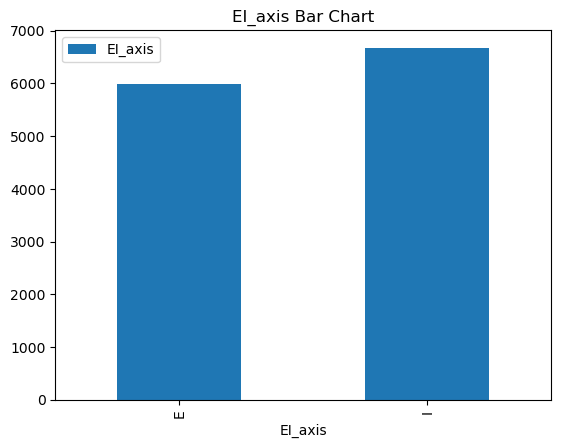

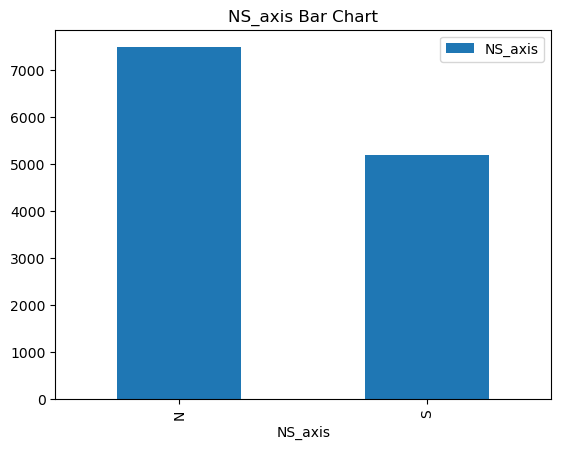

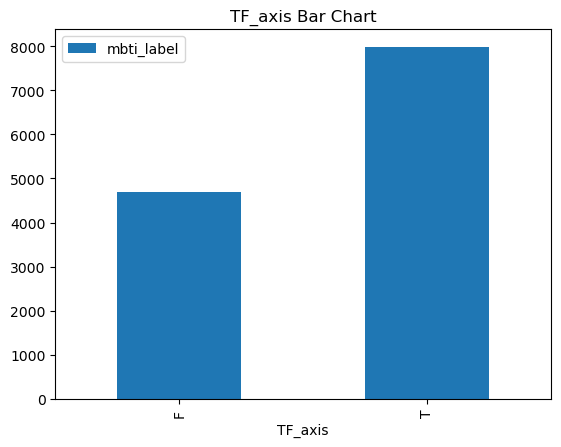

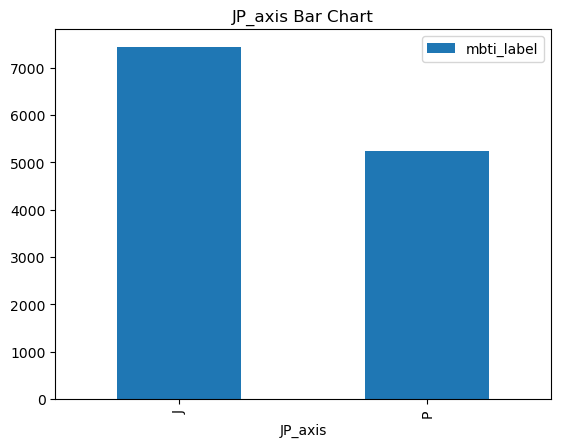

In [27]:
# Cell 9: Re-extract MBTI Axes on Augmented Data

merged_mbti = df_merged[['mbti_label']].copy()
merged_mbti['EI_axis'] = df_merged['mbti_label'].str.extract('(.)[N,S]', 1)
merged_mbti['NS_axis'] = df_merged['mbti_label'].str.extract('[E,I](.)[F,T]', 1)
merged_mbti['TF_axis'] = df_merged['mbti_label'].str.extract('[N,S](.)[J,P]', 1)
merged_mbti['JP_axis'] = df_merged['mbti_label'].str.extract('[F,T](.)', 1)

le_m = LabelEncoder()
mbti_axis_enc = merged_mbti[['mbti_label']].copy()
mbti_axis_enc['bin_EI'] = le_m.fit_transform(merged_mbti['EI_axis'])
mbti_axis_enc['bin_NS'] = le_m.fit_transform(merged_mbti['NS_axis'])
mbti_axis_enc['bin_TF'] = le_m.fit_transform(merged_mbti['TF_axis'])
mbti_axis_enc['bin_JP'] = le_m.fit_transform(merged_mbti['JP_axis'])

for axis, col in zip(['EI_axis','NS_axis','TF_axis','JP_axis'], ['EI_axis','NS_axis','mbti_label','mbti_label']):
    merged_mbti.groupby(axis).agg({col: 'count'}).plot(kind='bar')
    plt.title(f'{axis} Bar Chart')
    plt.show()

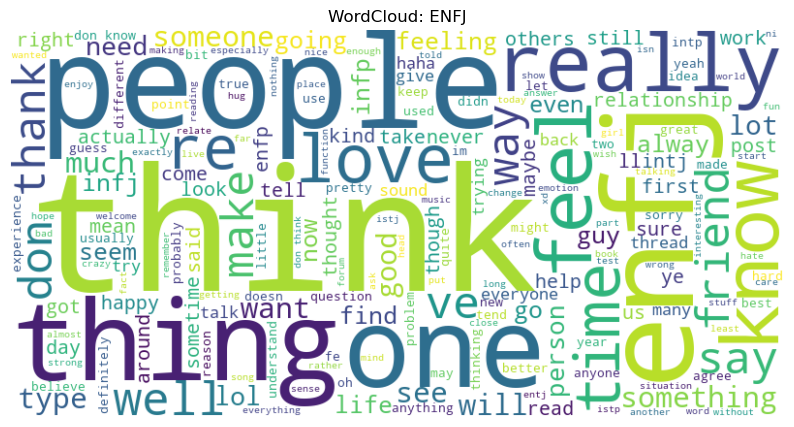

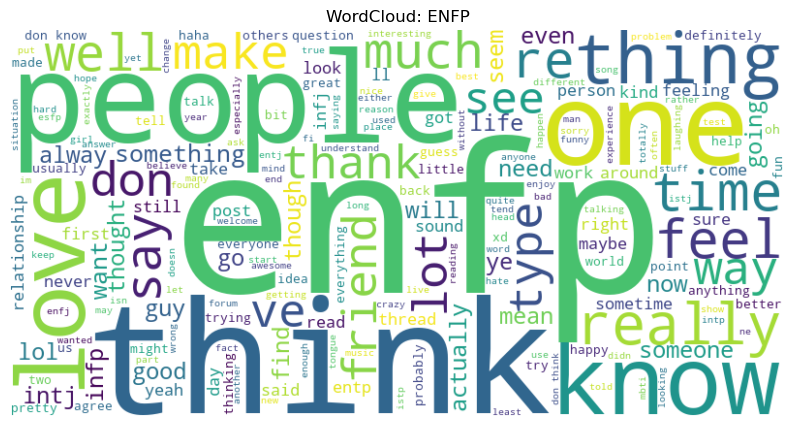

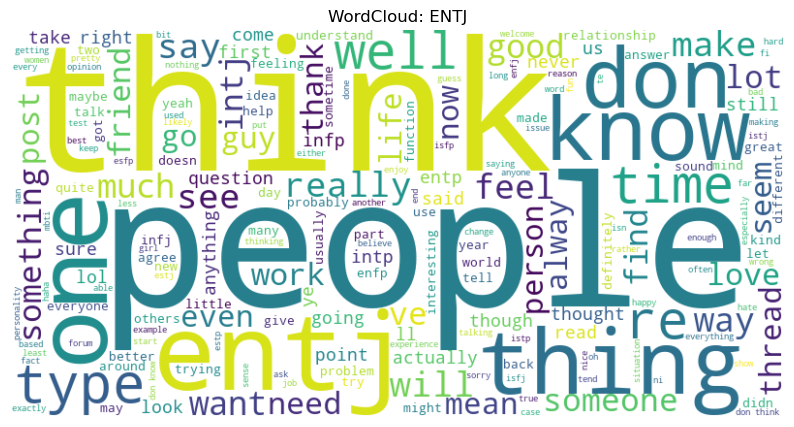

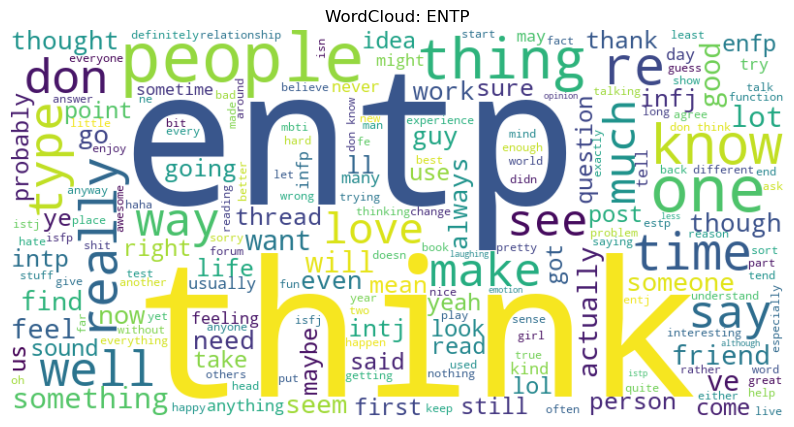

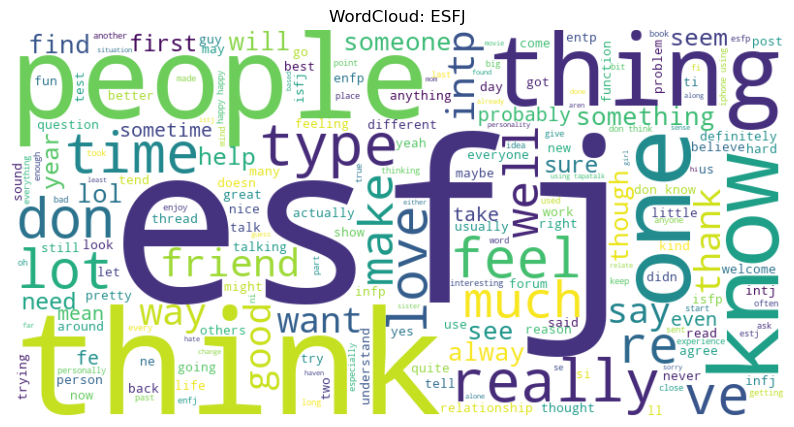

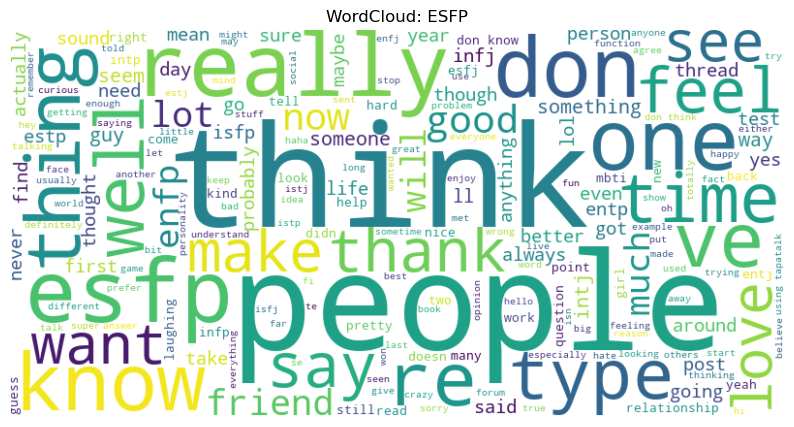

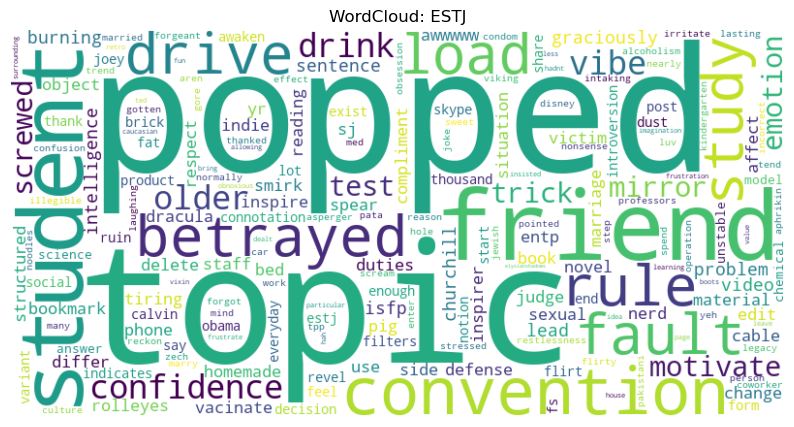

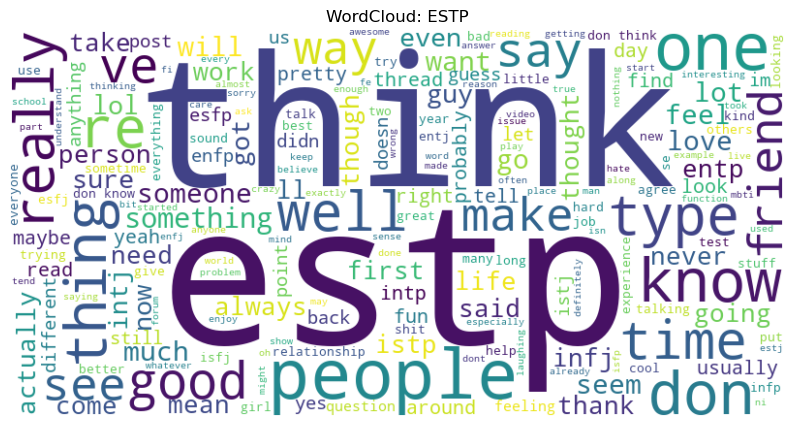

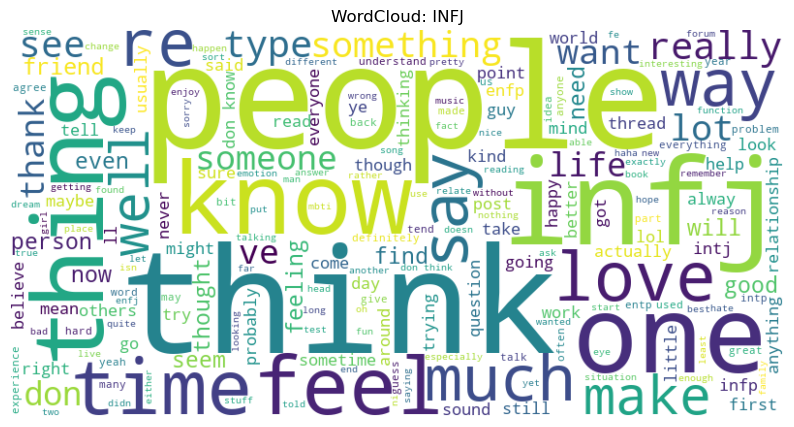

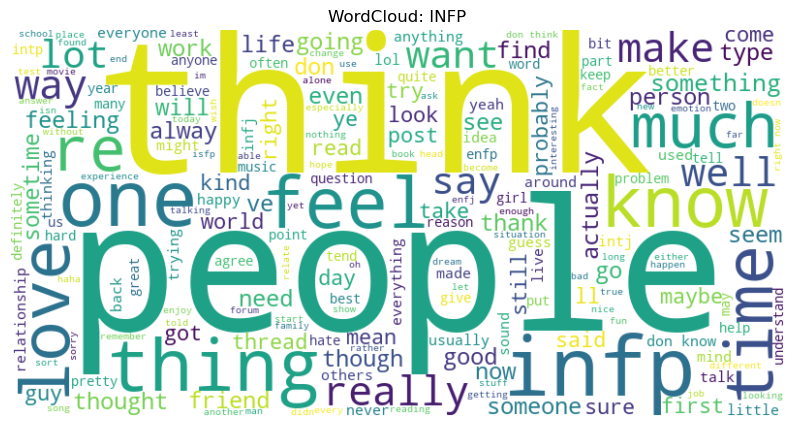

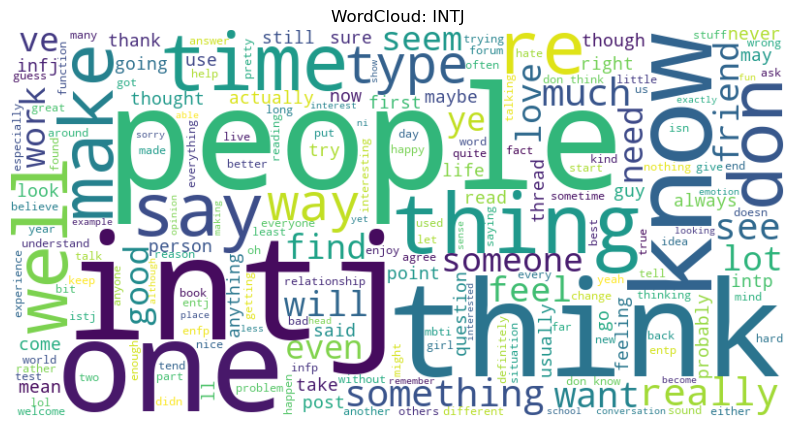

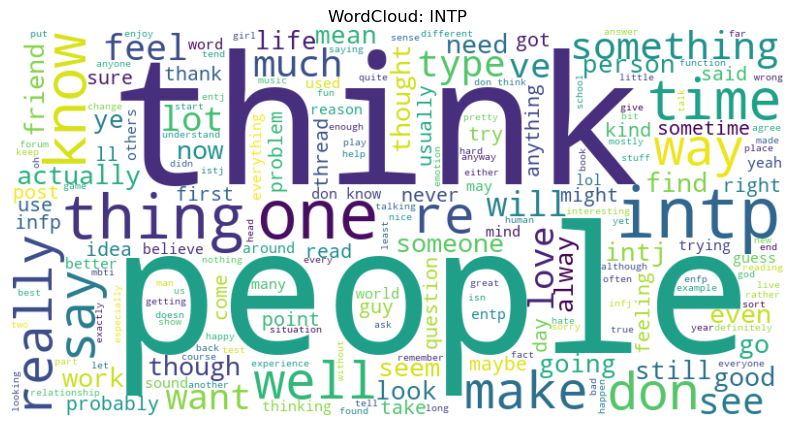

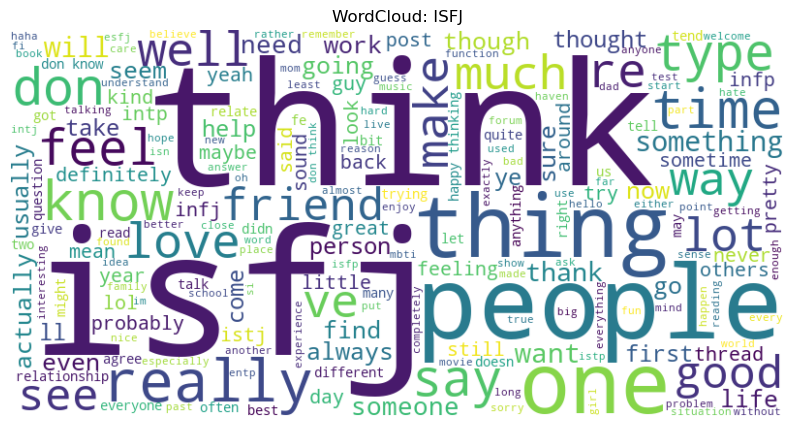

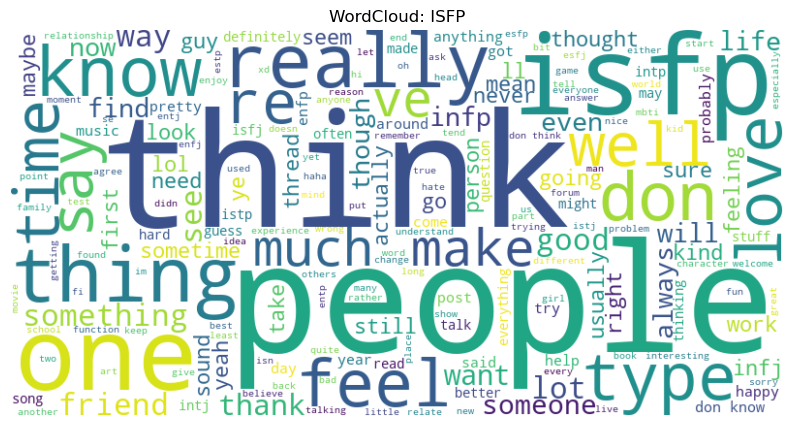

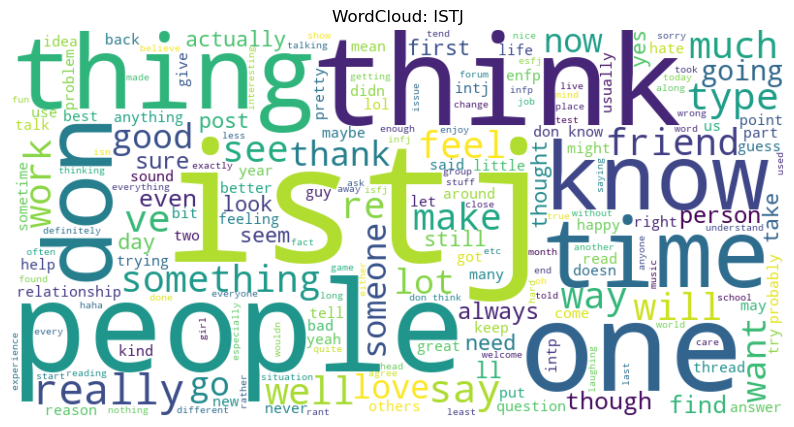

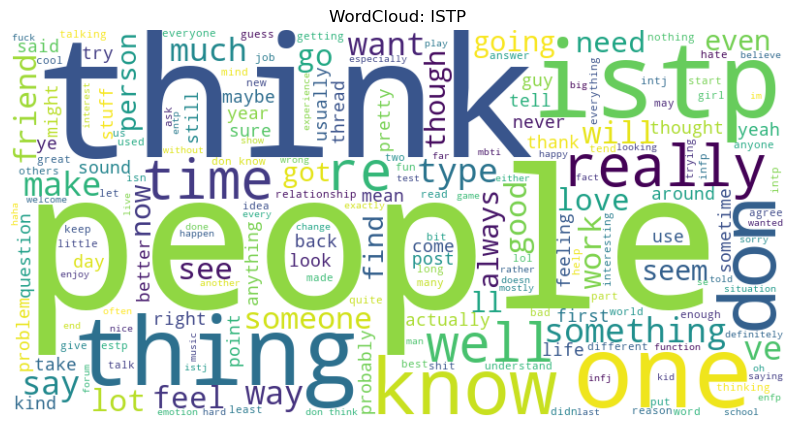

In [28]:
# Cell 10: Word Cloud Visuals

def show_word_cloud(texts, mbti_code):
    wc = WordCloud(width=800, height=400, background_color='white').generate(texts)
    plt.figure(figsize=(10,6))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'WordCloud: {mbti_code}')
    plt.show()

for label, group in df_merged.groupby('mbti_label'):
    text_all = ' '.join(group['clean_text'])
    show_word_cloud(text_all, label)

In [29]:
# Cell 11: Split Features/Targets

mbti_split = df_merged[['mbti_label', 'clean_text']].copy()
mbti_split['EI_axis'] = mbti_split['mbti_label'].str.extract('(.)[N,S]', 1)
mbti_split['NS_axis'] = mbti_split['mbti_label'].str.extract('[E,I](.)[F,T]', 1)
mbti_split['TF_axis'] = mbti_split['mbti_label'].str.extract('[N,S](.)[J,P]', 1)
mbti_split['JP_axis'] = mbti_split['mbti_label'].str.extract('[F,T](.)', 1)

le_target = LabelEncoder()
data_encoded = mbti_split[['mbti_label','clean_text']].copy()
data_encoded['bin_EI'] = le_target.fit_transform(mbti_split['EI_axis'])
data_encoded['bin_NS'] = le_target.fit_transform(mbti_split['NS_axis'])
data_encoded['bin_TF'] = le_target.fit_transform(mbti_split['TF_axis'])
data_encoded['bin_JP'] = le_target.fit_transform(mbti_split['JP_axis'])

X_input = data_encoded['clean_text'].values
Y_targets = data_encoded.drop(columns=['mbti_label', 'clean_text'])

In [30]:
# Cell 12: Training/Test Split, TF-IDF Setup

from sklearn.model_selection import train_test_split

X_tr, X_te, Y_tr, Y_te = train_test_split(X_input, Y_targets, random_state=42)

tfidf_model = TfidfVectorizer(
    max_features=17000,
    min_df=7,
    max_df=0.8,
    stop_words='english',
    ngram_range=(1,3)
)

X_tr_tfidf = tfidf_model.fit_transform(X_tr)
X_te_tfidf = tfidf_model.transform(X_te)

In [31]:
# Cell 13: Train Models for Each MBTI Dichotomy

mbti_keys = ['bin_EI', 'bin_NS', 'bin_TF', 'bin_JP']
nn_models = {}

for key in mbti_keys:
    ytrain_bin = Y_tr[key]
    ytest_bin = Y_te[key]

    net = Sequential()
    net.add(Embedding(input_dim=len(tfidf_model.get_feature_names_out()), output_dim=128))
    net.add(LSTM(64, return_sequences=True))
    net.add(LSTM(32, return_sequences=False))
    net.add(Dense(1, activation='sigmoid'))
    net.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    net.fit(X_tr_tfidf.toarray(), ytrain_bin, epochs=3, batch_size=32, validation_split=0.2)
    nn_models[key] = net

Epoch 1/3
238/238 ━━━━━━━━━━━━━━━━━━━━ 5073s 21s/step - accuracy: 0.5203 - loss: 0.6930 - val_accuracy: 0.5226 - val_loss: 0.6922
Epoch 2/3
238/238 ━━━━━━━━━━━━━━━━━━━━ 4805s 20s/step - accuracy: 0.5132 - loss: 0.6939 - val_accuracy: 0.5226 - val_loss: 0.6922
Epoch 3/3
238/238 ━━━━━━━━━━━━━━━━━━━━ 5259s 22s/step - accuracy: 0.5246 - loss: 0.6921 - val_accuracy: 0.5226 - val_loss: 0.6923
Epoch 1/3
238/238 ━━━━━━━━━━━━━━━━━━━━ 4490s 19s/step - accuracy: 0.5904 - loss: 0.6804 - val_accuracy: 0.5910 - val_loss: 0.6771
Epoch 2/3
238/238 ━━━━━━━━━━━━━━━━━━━━ 4922s 21s/step - accuracy: 0.5851 - loss: 0.6795 - val_accuracy: 0.5910 - val_loss: 0.6765
Epoch 3/3
238/238 ━━━━━━━━━━━━━━━━━━━━ 4976s 21s/step - accuracy: 0.5793 - loss: 0.6812 - val_accuracy: 0.5910 - val_loss: 0.6774
Epoch 1/3
238/238 ━━━━━━━━━━━━━━━━━━━━ 4087s 17s/step - accuracy: 0.6206 - loss: 0.6677 - val_accuracy: 0.6330 - val_loss: 0.6586
Epoch 2/3
238/238 ━━━━━━━━━━━━━━━━━━━━ 4008s 17s/step - accuracy: 0.6358 - loss: 0.6566 - 

In [32]:
# Cell 14: Evaluate Models

for key, net in nn_models.items():
    loss, acc = net.evaluate(X_te_tfidf.toarray(), Y_te[key])
    print(f'Dichotomy: {key}, Loss: {loss:.4f}, Accuracy: {acc:.4f}')

100/100 ━━━━━━━━━━━━━━━━━━━━ 149s 1s/step - accuracy: 0.5302 - loss: 0.6919
Dichotomy: bin_EI, Loss: 0.6916, Accuracy: 0.5355
100/100 ━━━━━━━━━━━━━━━━━━━━ 150s 1s/step - accuracy: 0.6028 - loss: 0.6741
Dichotomy: bin_NS, Loss: 0.6758, Accuracy: 0.5967
100/100 ━━━━━━━━━━━━━━━━━━━━ 149s 1s/step - accuracy: 0.6010 - loss: 0.6767
Dichotomy: bin_TF, Loss: 0.6670, Accuracy: 0.6172
100/100 ━━━━━━━━━━━━━━━━━━━━ 149s 1s/step - accuracy: 0.5941 - loss: 0.6755
Dichotomy: bin_JP, Loss: 0.6776, Accuracy: 0.5891


In [33]:
# Cell 15: Save Models and Vectorizer

if not os.path.exists('model'):
    os.makedirs('model')

for key, net in nn_models.items():
    net.save(f'model/{key}.h5')

with open('model/tfidf.pkl', 'wb') as file:
    pickle.dump(tfidf_model, file)